In [1]:
%matplotlib inline

In [2]:
import gc
import pathlib
import sys

In [3]:
import joblib
import lightgbm as lgb
import pandas as pd

In [4]:
root_dir_path = pathlib.Path("..")
data_dir_path = root_dir_path / "data"
processed_dir_path = data_dir_path / "processed"
train_path = processed_dir_path / "train_filtered.parquet"
models_dir_path = root_dir_path / "models"
model_path = models_dir_path / "model.joblib"
src_dir_path = root_dir_path / "src"

In [5]:
sys.path.append(str(src_dir_path))

In [6]:
from constants import *

In [7]:
train = pd.read_parquet(train_path)

In [8]:
is_train = train["date"] < "2016-01-29"
is_valid = train["date"] >= "2016-01-29"
train, valid = train[is_train], train[is_valid]

In [9]:
del is_train

In [10]:
gc.collect()

60

In [11]:
train.shape

(43375450, 35)

In [12]:
valid.shape

(2652507, 35)

In [13]:
X = train[features]
X_valid = valid[features]
y = train["demand"]
y_valid = valid["demand"]

In [14]:
del train
del valid

In [15]:
gc.collect()

100

In [16]:
model = lgb.LGBMRegressor(importance_type="gain", learning_rate=0.05, n_estimators=1_000, random_state=0)

In [17]:
model.fit(
    X,
    y,
    categorical_feature=categorical_features,
    early_stopping_rounds=100,
    eval_metric="rmse",
    eval_set=[(X, y), (X_valid, y_valid)],
)

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['cat_id', 'dept_id', 'event_name_1', 'event_name_2', 'event_type_1', 'event_type_2', 'item_id', 'state_id', 'store_id']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[1]	training's rmse: 4.20937	training's l2: 17.7188	valid_1's rmse: 3.53952	valid_1's l2: 12.5282
Training until validation scores don't improve for 100 rounds
[2]	training's rmse: 4.08091	training's l2: 16.6538	valid_1's rmse: 3.4291	valid_1's l2: 11.7587
[3]	training's rmse: 3.96094	training's l2: 15.689	valid_1's rmse: 3.32684	valid_1's l2: 11.0679
[4]	training's rmse: 3.84944	training's l2: 14.8182	valid_1's rmse: 3.23112	valid_1's l2: 10.4401
[5]	training's rmse: 3.7457	training's l2: 14.0302	valid_1's rmse: 3.14237	valid_1's l2: 9.87447
[6]	training's rmse: 3.64961	training's l2: 13.3197	valid_1's rmse: 3.05984	valid_1's l2: 9.3626
[7]	training's rmse: 3.56029	training's l2: 12.6757	valid_1's rmse: 2.98402	valid_1's l2: 8.9044
[8]	training's rmse: 3.4777	training's l2: 12.0944	valid_1's rmse: 2.91254	valid_1's l2: 8.48291
[9]	training's rmse: 3.40109	training's l2: 11.5674	valid_1's rmse: 2.84645	valid_1's l2: 8.10228
[10]	training's rmse: 3.33031	training's l2: 11.091	valid_1's 

[84]	training's rmse: 2.47816	training's l2: 6.14125	valid_1's rmse: 2.08586	valid_1's l2: 4.35081
[85]	training's rmse: 2.47723	training's l2: 6.13665	valid_1's rmse: 2.08537	valid_1's l2: 4.34875
[86]	training's rmse: 2.47611	training's l2: 6.13114	valid_1's rmse: 2.08498	valid_1's l2: 4.34714
[87]	training's rmse: 2.47528	training's l2: 6.12702	valid_1's rmse: 2.08468	valid_1's l2: 4.34589
[88]	training's rmse: 2.47439	training's l2: 6.12262	valid_1's rmse: 2.08424	valid_1's l2: 4.34407
[89]	training's rmse: 2.47366	training's l2: 6.119	valid_1's rmse: 2.08385	valid_1's l2: 4.34245
[90]	training's rmse: 2.47286	training's l2: 6.11504	valid_1's rmse: 2.08349	valid_1's l2: 4.34093
[91]	training's rmse: 2.47184	training's l2: 6.11	valid_1's rmse: 2.08332	valid_1's l2: 4.34022
[92]	training's rmse: 2.47093	training's l2: 6.10549	valid_1's rmse: 2.08328	valid_1's l2: 4.34005
[93]	training's rmse: 2.47016	training's l2: 6.10171	valid_1's rmse: 2.08286	valid_1's l2: 4.33832
[94]	training's

[167]	training's rmse: 2.42718	training's l2: 5.89119	valid_1's rmse: 2.07579	valid_1's l2: 4.30889
[168]	training's rmse: 2.42693	training's l2: 5.89001	valid_1's rmse: 2.07578	valid_1's l2: 4.30886
[169]	training's rmse: 2.42667	training's l2: 5.88875	valid_1's rmse: 2.07581	valid_1's l2: 4.309
[170]	training's rmse: 2.42599	training's l2: 5.88542	valid_1's rmse: 2.07582	valid_1's l2: 4.30902
[171]	training's rmse: 2.42579	training's l2: 5.88448	valid_1's rmse: 2.0758	valid_1's l2: 4.30894
[172]	training's rmse: 2.42554	training's l2: 5.88323	valid_1's rmse: 2.07556	valid_1's l2: 4.30795
[173]	training's rmse: 2.4248	training's l2: 5.87964	valid_1's rmse: 2.07572	valid_1's l2: 4.30862
[174]	training's rmse: 2.42447	training's l2: 5.87804	valid_1's rmse: 2.07545	valid_1's l2: 4.30748
[175]	training's rmse: 2.42409	training's l2: 5.87623	valid_1's rmse: 2.07531	valid_1's l2: 4.30692
[176]	training's rmse: 2.42366	training's l2: 5.87412	valid_1's rmse: 2.07532	valid_1's l2: 4.30695
[177

[250]	training's rmse: 2.402	training's l2: 5.76962	valid_1's rmse: 2.07553	valid_1's l2: 4.30783
[251]	training's rmse: 2.40165	training's l2: 5.76792	valid_1's rmse: 2.07611	valid_1's l2: 4.31023
[252]	training's rmse: 2.40143	training's l2: 5.76687	valid_1's rmse: 2.0761	valid_1's l2: 4.31018
[253]	training's rmse: 2.40108	training's l2: 5.76517	valid_1's rmse: 2.07611	valid_1's l2: 4.31025
[254]	training's rmse: 2.40091	training's l2: 5.76436	valid_1's rmse: 2.07603	valid_1's l2: 4.30988
[255]	training's rmse: 2.40066	training's l2: 5.76315	valid_1's rmse: 2.07611	valid_1's l2: 4.31023
[256]	training's rmse: 2.40037	training's l2: 5.7618	valid_1's rmse: 2.07584	valid_1's l2: 4.3091
[257]	training's rmse: 2.40025	training's l2: 5.76122	valid_1's rmse: 2.0759	valid_1's l2: 4.30934
[258]	training's rmse: 2.40001	training's l2: 5.76006	valid_1's rmse: 2.07582	valid_1's l2: 4.30904
[259]	training's rmse: 2.39973	training's l2: 5.75871	valid_1's rmse: 2.07605	valid_1's l2: 4.30997
[260]	

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='gain', learning_rate=0.05, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=1000, n_jobs=-1, num_leaves=31, objective=None,
              random_state=0, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

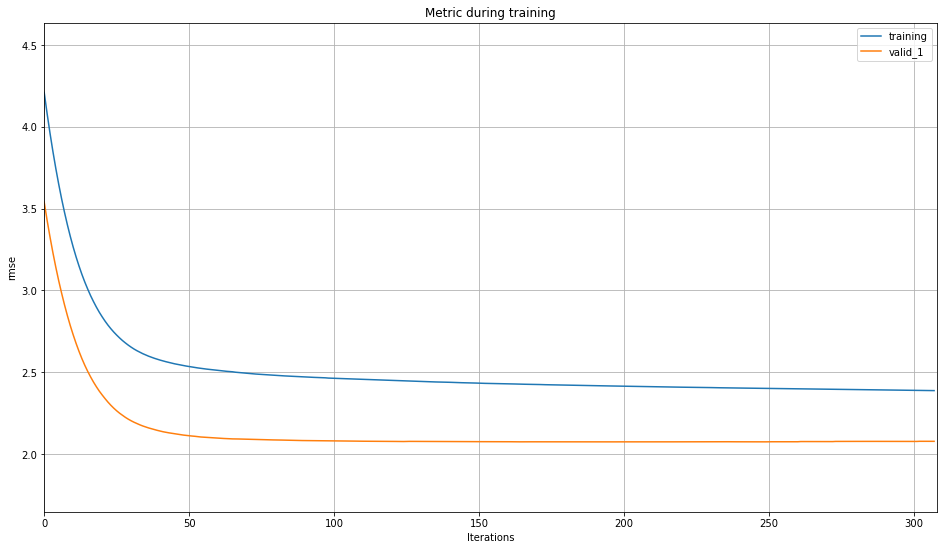

In [18]:
ax = lgb.plot_metric(model, metric="rmse", figsize=(16, 9))

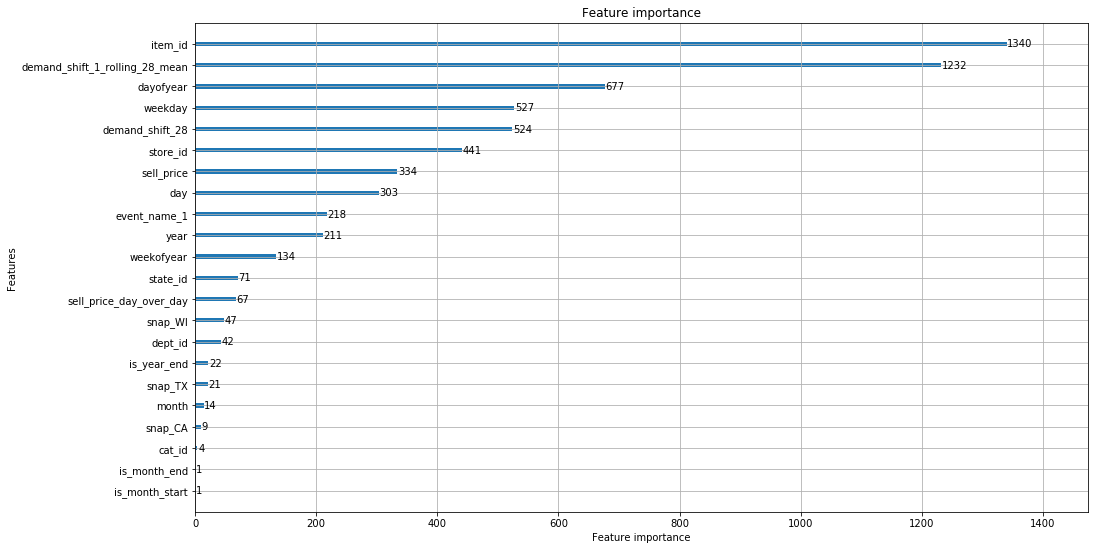

In [19]:
ax = lgb.plot_importance(model, figsize=(16, 9))

In [20]:
joblib.dump(model, model_path)

['../models/model.joblib']